# Least Square Method - 2D

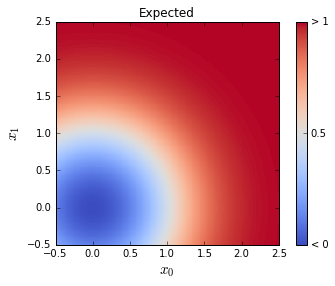

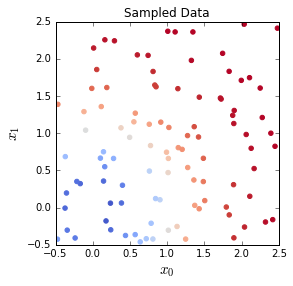

In [270]:
%matplotlib inline

import numpy as np
from numpy import random
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.cm as cm 

def f_exp(x0, x1, coef=None):
    return (1 / (1 + np.exp(-1 * (np.power(x0, 2) + np.power(x1, 2)))) - 0.5) * 2
    
def plot_f(f, opt):
    n = 256 
    x = np.linspace(-0.5, 2.5, n) 
    y = np.linspace(-0.5, 2.5, n) 
    X, Y = np.meshgrid(x, y) 

    Z = f(X, Y, opt['coef'])

    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.axis([-0.5, 2.5, -0.5, 2.5])
    ax.set_title(opt['title'])
    ax.set_xlabel(u'$x_0$', fontsize=15)
    ax.set_ylabel(u'$x_1$', fontsize=15)

    cax = ax.pcolormesh(X, Y, Z, cmap=cm.coolwarm, vmin=0, vmax=1)
    cbar = fig.colorbar(cax, ticks=[0, 0.5, 1])
    cbar.ax.set_yticklabels(['< 0', '0.5', '> 1'])
    
    return ax

def plot_data(x, f, opt):
    
    if 'ax' in opt:
        ax = opt['ax']
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, aspect='equal')
        
    ax.axis([-0.5, 2.5, -0.5, 2.5])
    ax.set_title(opt['title'])
    ax.set_xlabel(u'$x_0$', fontsize=15)
    ax.set_ylabel(u'$x_1$', fontsize=15)

    z = f(x[:,0], x[:,1], opt['coef'])
    z = np.squeeze(np.asarray(z))
    
    colors = cm.coolwarm((z * 256).astype(int))

    ax.scatter(x[:,0], x[:,1], color=colors)
    
    return ax

plot_f(f_exp, {'title':u'Expected', 'coef':None})

random.seed(2)
N = 100
x =  np.dot((random.rand(N,2) - 0.5) * 2, np.array([[1.5, 0], [0, 1.5]])) + np.array([[1, 1]])
z = f_exp(x[:,0], x[:,1])

plot_data(x, f_exp, {'title':u'Sampled Data', 'coef':None})



In [271]:
''' 
x: input data (shape = (N, D))
k: degree of polynomial function (scalar)
retrun: expanded input, [1 x_1 x_2 x^2_1 x^2_2... x^k_1 x^k_2] (shape= (N,1+D*k))
'''
def buildX(x, k):
    X = np.ones((x.shape[0], 1))
    for i in range(k):
        X = np.hstack((X, np.power(x, i + 1)))
    
    return np.matrix(X)

assert(np.array_equal(buildX(np.matrix([[1, 2, 3],[4, 5, 6]]).T, 2), 
       np.matrix([[1, 1, 4, 1, 16], [1, 2, 5, 4, 25], [1, 3, 6, 9, 36]])))

'''
a: coefficients of polynomial function (shape = (1+k, 1))
x: input data (shape = (N, D))
return: f(x:a) (shape = (N, 1))
'''
def evaluate(a, x):
    D = x.shape[1]
    k = (a.shape[0] - 1) / D
    
    X = buildX(x, k)
    f = X.dot(a)
    
    return f

assert(np.array_equal(evaluate(np.matrix([2, 3, 4]).T, np.matrix([[2, 3], [1, 1]])),
                     np.matrix([[20],[9]])))

'''
x0, x1: array (length = N)
a: coefficients (shape=(N,1)) 
'''
def f_poly(x0, x1, a):
    D = 2
    k = (a.shape[0] - 1) / D
    
    f = np.ones_like(x0) * a[0, 0]
    for i in range(k):
        f += a[i * 2 + 1, 0] * x0 ** (i + 1)
        f += a[i * 2 + 2, 0] * x1 ** (i + 1)
        
    return f
    
test_x0 = np.linspace(1, 2, 2) 
test_x1 = np.linspace(0, 3, 2) 
test_X0, test_X1 = np.meshgrid(test_x0, test_x1) 

assert(np.array_equal(
        f_poly(test_X0, test_X1, np.matrix([1, 2, 3]).T),
        np.matrix([[3, 5],[12, 14]])))

'''
d: desired values (shape=(N,1))
o: output (shape=(N,1))
return: half of sum of squred error (shape= (1,1))
'''
def sqrErr(d, o):
    return np.sum(np.power(d - o, 2), 0) / 2.



[Least Squares Fitting - Polynomial](http://mathworld.wolfram.com/LeastSquaresFittingPolynomial.html)  
$a = (X^T X)^{-1} X^T y$

In [272]:

'''
X: expanded input (shape=(N, 1+k*D))
y: expected output (shape=(N, 1))
return: coefficients (shape=(1+k*D, 1))
'''
def fit(X, y):
    a = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y).T
    return a

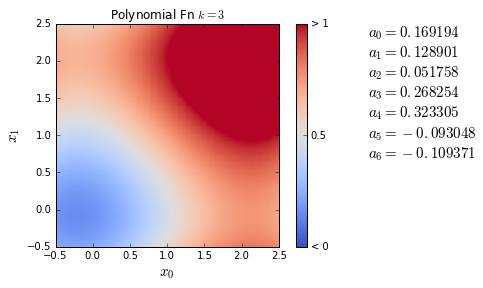

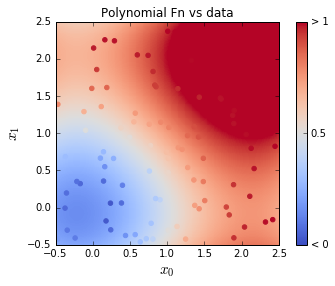

In [273]:
k = 3

X = buildX(x, k)

a = fit(X, z)

ax = plot_f(f_poly, {'title':u'Polynomial Fn $k = %d$' % k, 'coef':a})
ax.text(1.4, 1, '\n'.join('$a_{%d} = %f$' % (i, a[i]) for i in range(a.shape[0])), 
            transform=ax.transAxes, verticalalignment='top', fontsize=15)
    

ax = plot_f(f_poly, {'title':u'', 'coef':a})
ax = plot_data(x, f_exp, {'title':u'Polynomial Fn vs data', 'coef':None, 'ax':ax})


## Least Square Method - 2D - Polynomial + Gradient Descent

In [274]:
def plot_GD(epoch, a, X, y, err):
    ax = plot_f(f_poly, {'title':u'', 'coef':a})
    ax = plot_data(X[:, 1:3], f_exp, {'title':u'Polynomial Fn vs data, epoch = %d' % epoch, 'coef':None, 'ax':ax})

    
    ax.text(1.4, 1, u'$E = %f$' % err, 
                transform=ax.transAxes, fontsize=15)

    ax.text(1.4, 0.95, '\n'.join('$a_{%d} = %f$' % (i, a[i]) for i in range(a.shape[0])), 
                transform=ax.transAxes, verticalalignment='top', fontsize=15)

def fit_GD(X, y, epoch, mu):

    a = np.zeros([X.shape[1], 1])
    
    E = 0
    
    for i in range(epoch):
        
        f = X.dot(a)
        e = y - f
        E = 0.5 * np.sum(np.power(e, 2))

        if (i % (epoch / 10) == 0):
            plot_GD(i, a, X, y, E)

        gradE = - e.T.dot(X).T
        
        a -= mu * gradE.sum(1)


    plot_GD(epoch, a, X, y, E)
    
    return a

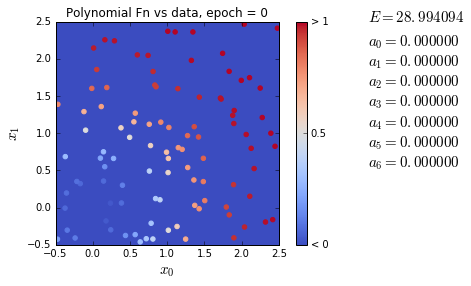

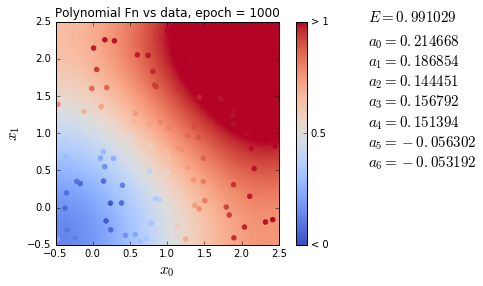

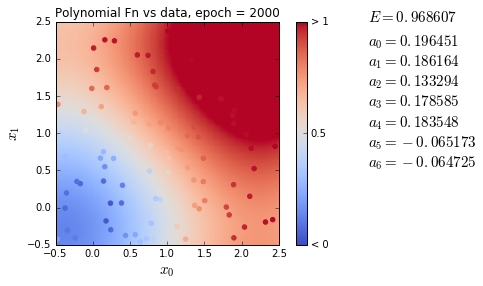

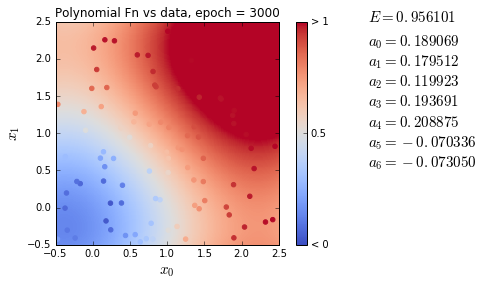

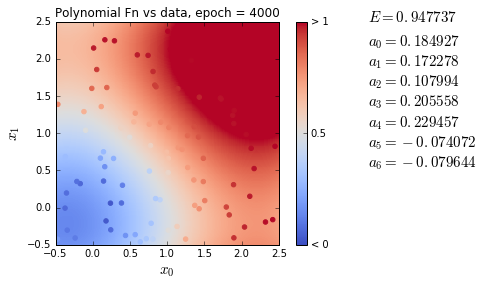

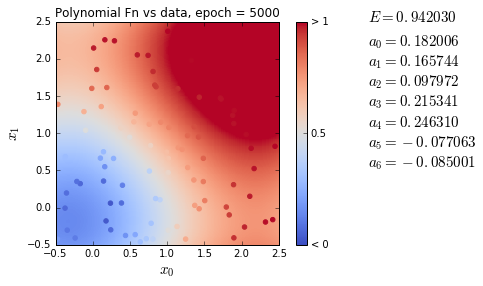

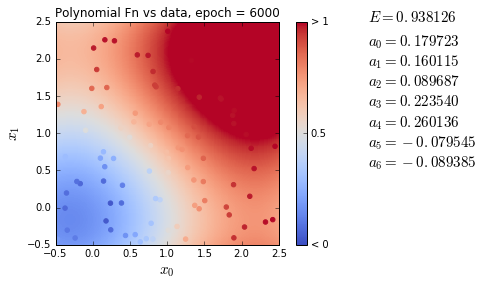

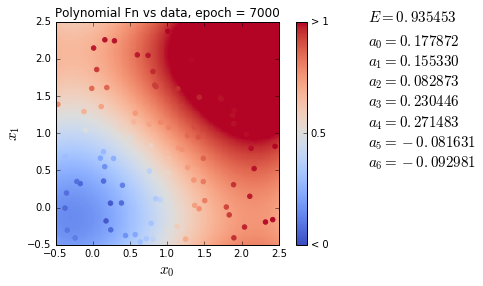

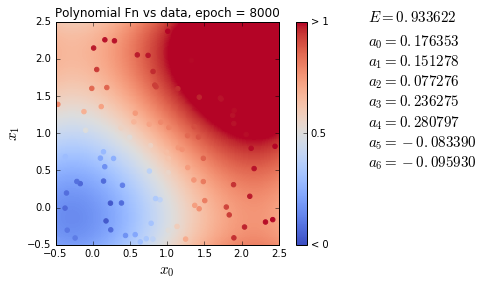

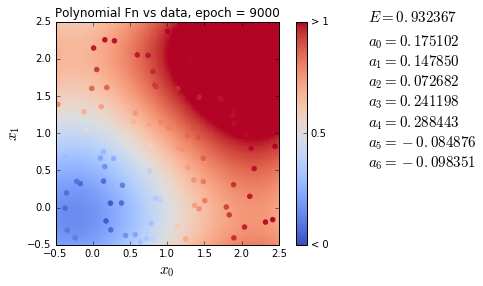

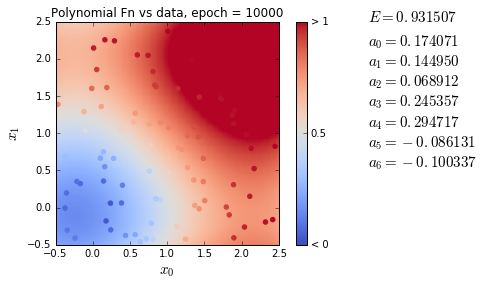

In [275]:
mu = 0.0001

epoch = 10000

a = fit_GD(X, np.matrix(z).T, epoch, mu)